In [ ]:
#IMPORTS
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt




#make it device agnostic code

if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
else:
    device="cpu"
print(f"Device using: {device}")


Device using: mps


In [392]:
#make the data:

weight = 0.7
bias = 0.3

X_data = torch.arange(start=1,end=10,step=0.1) #the features
Y_data = weight * X_data + bias #the labels (ground truth)
X_data[:10], Y_data[:10] #where



(tensor([1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
         1.9000]),
 tensor([1.0000, 1.0700, 1.1400, 1.2100, 1.2800, 1.3500, 1.4200, 1.4900, 1.5600,
         1.6300]))

In [ ]:
#Train-Test Split
train_test_ratio = (0.8,0.2)
split_index = int(X_data.shape[0]*train_test_ratio[0]) #can also use the len(X_data) * 0.8
X_train, X_test = X_data[:split_index].to(device).unsqueeze(dim=1), X_data[split_index:].to(device).unsqueeze(dim=1)
Y_train, Y_test = Y_data[:split_index].to(device).unsqueeze(dim=1), Y_data[split_index:].to(device).unsqueeze(dim=1)
X_train[:10], X_test[:10], Y_train[:10], Y_test[:10]
#len(X_train), len(X_test), len(Y_train), len(Y_test)






(tensor([[1.0000],
         [1.1000],
         [1.2000],
         [1.3000],
         [1.4000],
         [1.5000],
         [1.6000],
         [1.7000],
         [1.8000],
         [1.9000]], device='mps:0'),
 tensor([[8.2000],
         [8.3000],
         [8.4000],
         [8.5000],
         [8.6000],
         [8.7000],
         [8.8000],
         [8.9000],
         [9.0000],
         [9.1000]], device='mps:0'),
 tensor([[1.0000],
         [1.0700],
         [1.1400],
         [1.2100],
         [1.2800],
         [1.3500],
         [1.4200],
         [1.4900],
         [1.5600],
         [1.6300]], device='mps:0'),
 tensor([[6.0400],
         [6.1100],
         [6.1800],
         [6.2500],
         [6.3200],
         [6.3900],
         [6.4600],
         [6.5300],
         [6.6000],
         [6.6700]], device='mps:0'))

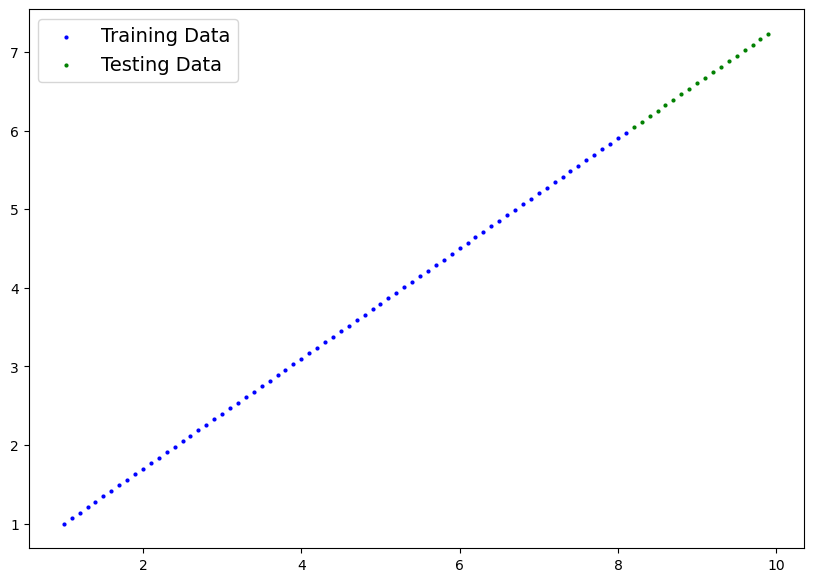

In [394]:
# visualize the data, make the plot_predictions function
#DETACH AND CPU are not the same function, y=x.cpu() will either do nothing if on cpu or return a new tensor on the cpu
# y=x.detach() will disconnect the graph between x and y and return a view of x to y with memory shared



def plot_predictions(training_features=X_train.cpu(), training_labels=Y_train.cpu(), testing_features=X_test.cpu(), 
                     testing_labels=Y_test.cpu(), predictions=None):
    plt.figure(figsize=(10,7))

    plt.scatter(training_features,training_labels, c="b", s=4, label="Training Data")
    plt.scatter(testing_features, testing_labels, c="g", s=4, label = "Testing Data")

    if predictions is not None:
        predictions=predictions.cpu()
        plt.scatter(testing_features, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size":14}) #changes the size of the legend

plot_predictions()
    


In [395]:
#Now we make the model:



#weights is (out_features,in_features), imput should be (batch_size, in_features)
# and bias is size out_features, and is broadcasted to size (batch_size, out_features)
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)  # this is how you pass data in with a linear layer, it has its own forward funciton you can use

torch.manual_seed(42)
model = LinearRegressionModel()
print(f"State dict is {model.state_dict()}, and the parameters are {model.parameters()}")

print(f"device used = {next(model.parameters()).device}") #even though you set device to gpu at the top, model is still
#initially on the cpu, which must be moved!!!
#NOTE: model.parameters() returns a generator of all the nn.Parameter objects the model contains
#to access only one of them, can use the next command, which returns the next one in an iterator object



#TO MOVE YOUR MODEL TO THE GPU:
model.to(device)
print(f"now, the model is on: {next(model.parameters()).device}")


State dict is OrderedDict({'linear_layer.weight': tensor([[0.7645]]), 'linear_layer.bias': tensor([0.8300])}), and the parameters are <generator object Module.parameters at 0x33b7dea40>
device used = cpu
now, the model is on: mps:0


shape of x : torch.Size([18, 1])


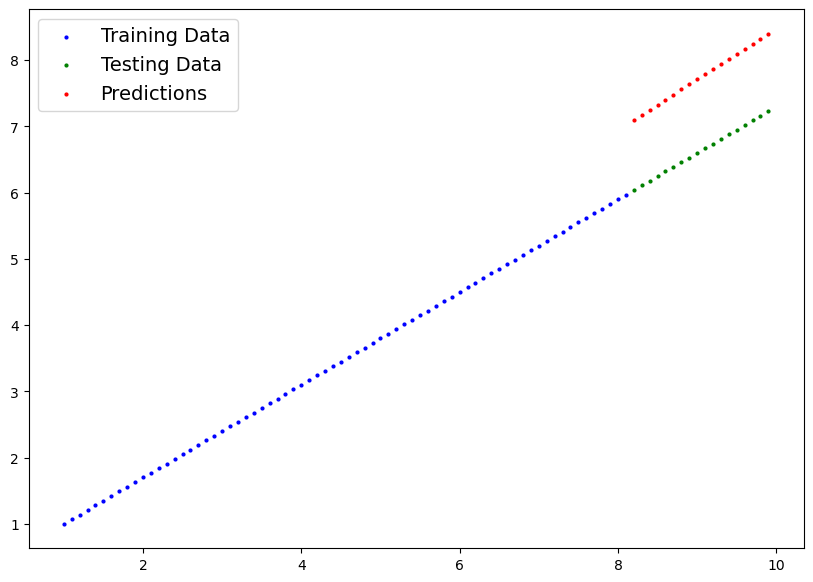

In [396]:
#Now, we need to find the loss and optimizer
# for linear tasks, use the Mean Absolute Error loss function, and the Stochastic Gradient Descent Optimizer

model.eval()

print(f"shape of x : {X_test.shape}")
#print(f"shape of x unsqueezed: {X_test.unsqueeze(dim=1)}")


with torch.inference_mode():
    y_preds = model(X_test)

plot_predictions(predictions=y_preds)

#ERROR: it says error: dimension out of range, expected [-1,0] but got [-2], this means 
# your tensor has 1 dimension, valid dimensional indices are -1 (last dim), or 0 (first dim), but you tried -2, which 
#is out of range

#IMPORTANT EXAMPLE: if tensor shape is (2,3,4), valid indicies are (-3,-2,-1,0,1,2)

In [397]:
#Now we choose our loss function and optimizer

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001) #remember you need to pass to the optimizer which params 
#and which lr to use

In [398]:
#training + testing loop

epochs = 1500
train_loss_values = [] #this is how you define an empty list in pytorch
test_loss_values = []
number_of_epochs = []

for epoch in range(epochs): #NOTE: integers are not iterable, must use a range

    #first, you do a forward pass on the model with the training data
    model.train()

    y_preds = model(X_train)

    #next, you calculate the loss value of your obtained values

    loss = loss_fn(y_preds, Y_train)

    # now that your loss is calculates, you want to zero the gradients to prepare for backprop

    optimizer.zero_grad()

    #next, we want to backwards propagate through the data and using the computational graph pytorch made
    #find the gradient with respect to each parameter in the model vs the loss function

    loss.backward()

    #now, we want to step out optimizer, which means it will change the parameters in our model to lower
    #the loss

    optimizer.step()

    #NOW THE TESTING LOOP:

    model.eval() #first bring the model in eval mode

    #then, using inference mode, forward pass through the testing data
    #NOTE: the entire testing block must be in inference mode
    with torch.inference_mode():
        test_preds = model(X_test)
    
        #then, record the loss of the testing data
        test_loss = loss_fn(test_preds, Y_test)

        if epoch % 10 == 0: #here, use the == 0
            print(f"Current Epoch: {epoch} | MAE Train Loss : {loss} | MAE Test Loss : {test_loss}")
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            number_of_epochs.append(epoch)






Current Epoch: 0 | MAE Train Loss : 0.823658287525177 | MAE Test Loss : 1.071904182434082
Current Epoch: 10 | MAE Train Loss : 0.606634259223938 | MAE Test Loss : 0.6501309275627136
Current Epoch: 20 | MAE Train Loss : 0.389610230922699 | MAE Test Loss : 0.22835798561573029
Current Epoch: 30 | MAE Train Loss : 0.19155487418174744 | MAE Test Loss : 0.1558833122253418
Current Epoch: 40 | MAE Train Loss : 0.17284061014652252 | MAE Test Loss : 0.2487252801656723
Current Epoch: 50 | MAE Train Loss : 0.1708102524280548 | MAE Test Loss : 0.26846539974212646
Current Epoch: 60 | MAE Train Loss : 0.16952073574066162 | MAE Test Loss : 0.2731725871562958
Current Epoch: 70 | MAE Train Loss : 0.16834856569766998 | MAE Test Loss : 0.2719360589981079
Current Epoch: 80 | MAE Train Loss : 0.16717229783535004 | MAE Test Loss : 0.2692139148712158
Current Epoch: 90 | MAE Train Loss : 0.1660001575946808 | MAE Test Loss : 0.2679775655269623
Current Epoch: 100 | MAE Train Loss : 0.16482381522655487 | MAE Test

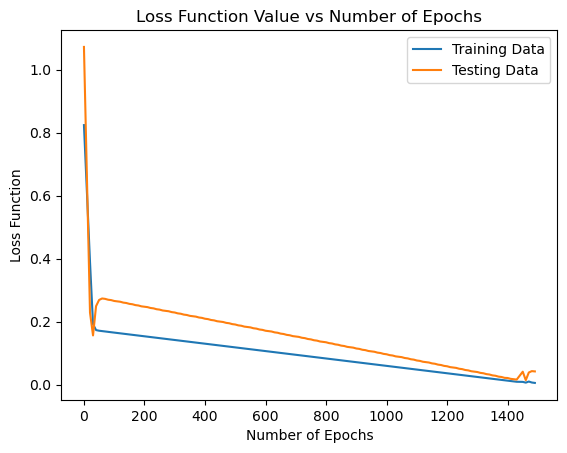

In [399]:
#Now, it is time to plot the test and training loss functions over epochs

plt.plot(number_of_epochs,train_loss_values, label="Training Data") #enter the data (x, y)
plt.plot(number_of_epochs,test_loss_values, label="Testing Data")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function")
plt.title("Loss Function Value vs Number of Epochs")
plt.legend()

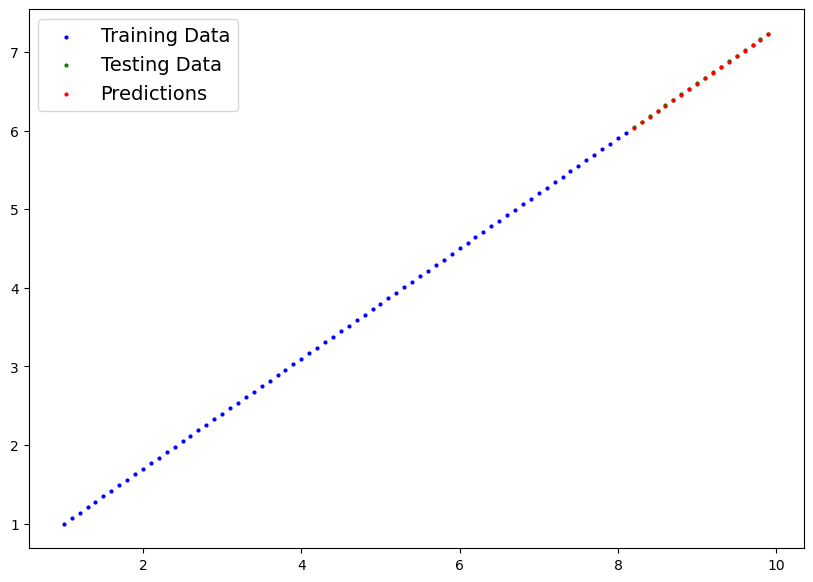

In [400]:
# now, lets see how close our predictions were
model.eval()
with torch.inference_mode():
    final_preds = model(X_test)


plot_predictions(predictions=final_preds)

In [401]:
#Now, we should try saving our model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) #dont need to define it
#now the path obeject has the path to the file

MODEL_NAME = "LinearModel_Remake"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#now, created a new path variable that holds my file

#now, we can save the state_dict of our model
print(f"Saving the model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving the model to : models/LinearModel_Remake


The final values for the weights and bias found were: OrderedDict({'linear_layer.weight': tensor([[0.6985]], device='mps:0'), 'linear_layer.bias': tensor([0.3105], device='mps:0')})


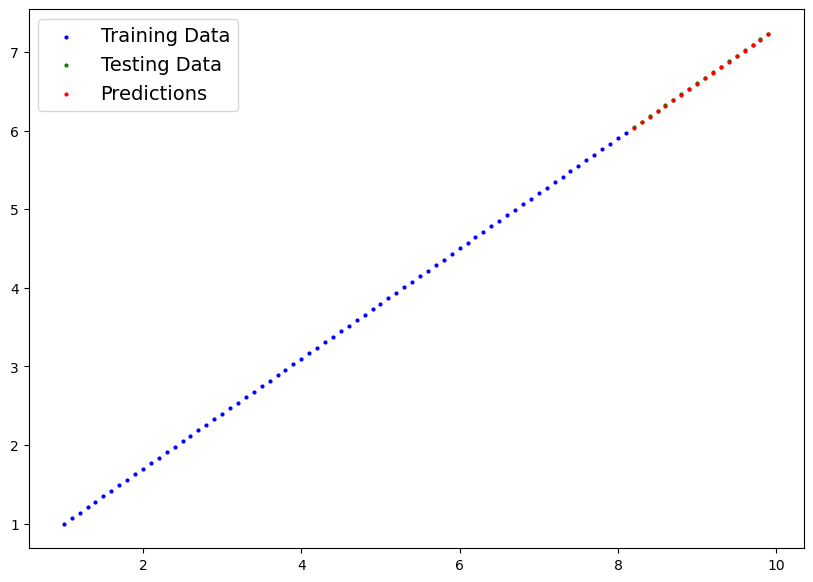

In [402]:
#Now, lets load that object back into our system

model_loaded = LinearRegressionModel()
model_loaded.to(device)

model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

#we can test that it worked by doing inference on our model:

model_loaded.eval()

with torch.inference_mode():
    loaded_preds = model_loaded(X_test)
    print(f"The final values for the weights and bias found were: {model_loaded.state_dict()}")
plot_predictions(predictions=loaded_preds)